In [115]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

connct = psycopg2.connect('dbname=WhiskyAdvocate user= postgres password = [redacted] host = 127.0.0.1 port=5432')

#Query the database to recover the needed data for unsupervised learning operations

ds_query = ''' SELECT whiskey_id, fruity_words, wood_words, spicy_words, sweet_words, maillard_words, smoke_words
                FROM features_rev'''

ml_df_full = pd.read_sql(ds_query, connct)

ml_df_full.head()

,whiskey_id,fruity_words,wood_words,spicy_words,sweet_words,maillard_words,smoke_words
0,0,2,1,2,0,0,0
1,1,2,0,0,1,2,0
2,2,1,2,1,1,1,0
3,3,1,0,0,3,0,0
4,4,2,0,0,3,1,0


In [3]:
#connct.close()

I am choosing DBSCAN for clustering analysis because there are a lot of points that look like noise points, and a lot of the points look like noise points. Kmeans and agglomerative clustering are bad for irregular shaped clusters. 

In [116]:
#git rid of whiskey_id

ml_df = ml_df_full.drop(['whiskey_id'], axis = 1)

#check for missing values
ml_df.isnull().sum()

fruity_words      0
wood_words        0
spicy_words       0
sweet_words       0
maillard_words    0
smoke_words       0
dtype: int64

In [117]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5900 entries, 0 to 5899
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   fruity_words    5900 non-null   int64
 1   wood_words      5900 non-null   int64
 2   spicy_words     5900 non-null   int64
 3   sweet_words     5900 non-null   int64
 4   maillard_words  5900 non-null   int64
 5   smoke_words     5900 non-null   int64
dtypes: int64(6)
memory usage: 276.7 KB


I am going to try implementing the DBSCAN clustering alogrythm using scikit learn. I have questions about how well it will work. If it doesn't work, I don't think other clustering algorythms are necessarily likely to work better because of the irregular appearance of some of the clusters when I run t-SNE. An idea I have for refactoring the project is to combine features that seem related - for instance sugar, sweet and honey could all go in the same features, and some of the fruit descriptors could be summed in another feature. This reduceds the dimensionality of the feature space along defensible lines, and may make it easier to spot clusters and patterns.  

In [118]:
#import some necessary things from sklearn

import sklearn
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN


In [119]:
#scale the data using minmaxscaler

scaler = MinMaxScaler().fit(ml_df)

ml_scale = scaler.transform(ml_df)

ml_scale

array([[0.18181818, 0.125     , 0.25      , 0.        , 0.        ,
        0.        ],
       [0.18181818, 0.        , 0.        , 0.16666667, 0.25      ,
        0.        ],
       [0.09090909, 0.25      , 0.125     , 0.16666667, 0.125     ,
        0.        ],
       ...,
       [0.09090909, 0.        , 0.25      , 0.16666667, 0.25      ,
        0.        ],
       [0.09090909, 0.        , 0.        , 0.        , 0.25      ,
        0.        ],
       [0.18181818, 0.125     , 0.        , 0.        , 0.375     ,
        0.        ]])

In [120]:
#I used min max scaler, which should put all the features between 0 and 1. this means my epsilon (neighborhood) value for 
#DBSCAN needs to be small. I'm going to start with 0.05
#min samples should be kind of large because there are 5900 points in the set. 25 seems like a reasonable value to start. 

cls_1 = DBSCAN(eps = 0.1, min_samples = 25).fit_predict(ml_scale)

cls_1

array([ 0, -1,  1, ..., -1, 30, -1], dtype=int64)

In [121]:
# my preferred t-SNE parameters were tsne15 = TSNE(random_state=42, perplexity = 40, learning_rate = 1000)
#copying over my helpful t-SNE functions for visualizing my clustering

def tsne_unpack(tsne_array, list1, list2):
    for t in tsne_array:
        list1.append(t[0])
        list2.append(t[1])

def visny_tsne(tsne_instantiation):
    
    ws_tsne_iter = tsne_instantiation.fit_transform(ml_scale)
    
    tsne_x = []
    tsne_y = []
    
    tsne_unpack(ws_tsne_iter, tsne_x, tsne_y)
    
    plt.figure(figsize = (12, 12))
    sns.scatterplot(x = tsne_x, y = tsne_y)
    plt.show()


In [122]:
#constructing a dataframe for t-SNE visualization of clustering
pref_tsne = TSNE(random_state=42, perplexity = 50, learning_rate = 1000, early_exaggeration = 30)

db_tsne1 = pref_tsne.fit_transform(ml_scale)

pref_tsne_x = []
pref_tsne_y = []

tsne_unpack(db_tsne1, pref_tsne_x, pref_tsne_y)

vis1_dict = {'tSNE_x': pref_tsne_x, 'tSNE_y':pref_tsne_y}

vis_1 = pd.DataFrame(vis1_dict)

vis_1.head()

,tSNE_x,tSNE_y
0,17.502785,56.396896
1,5.344396,-61.841087
2,-38.810066,-10.793710
3,-33.354923,-68.098503
4,-34.349125,-66.084190


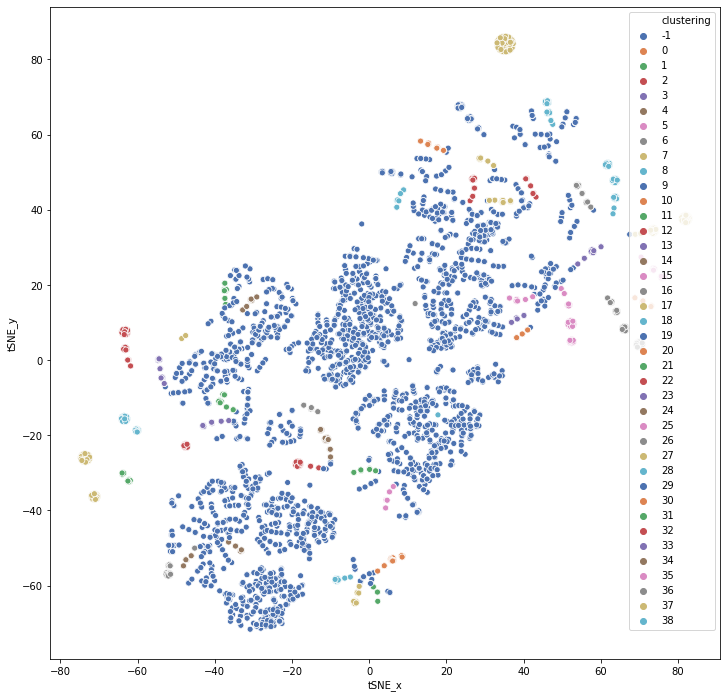

In [123]:
# adding clustering data as a new column, and visualizing

vis_1['clustering'] = cls_1

plt.figure(figsize = (12, 12))
sns.scatterplot(data = vis_1, x = 'tSNE_x', y = 'tSNE_y', hue = 'clustering', palette = 'deep')

plt.show()

Lots of little clusters. Needs optimization, but we might get something like this. 

In [124]:
# I am going to use the elbow method for deciding my epsilon value
# I used a similar method to Chelsea Pelleriti https://www.youtube.com/watch?v=0V2r7SGP2ZM

from sklearn.neighbors import NearestNeighbors

#set mins argument (what distance do you want nearest neighbors to go by)
# I will start with 25 but may reduce this number
mins = 25

nn = NearestNeighbors(mins + 1)

nn.fit(ml_scale)

distances, neighbors = nn.kneighbors(ml_scale)

distances

C:\Users\gspah\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=26 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([[0.        , 0.        , 0.        , ..., 0.09090909, 0.09090909,
        0.09090909],
       [0.        , 0.        , 0.        , ..., 0.125     , 0.125     ,
        0.125     ],
       [0.        , 0.        , 0.        , ..., 0.09090909, 0.09090909,
        0.09090909],
       ...,
       [0.        , 0.        , 0.        , ..., 0.125     , 0.125     ,
        0.125     ],
       [0.        , 0.        , 0.        , ..., 0.09090909, 0.09090909,
        0.09090909],
       [0.        , 0.        , 0.        , ..., 0.125     , 0.125     ,
        0.14285714]])

In [125]:
len(distances)

5900

In [126]:
distances = np.sort(distances[:, mins], axis = 0)

distances

array([0.        , 0.        , 0.        , ..., 0.57099438, 0.61237244,
       0.86435773])

In [127]:
len(distances)

5900

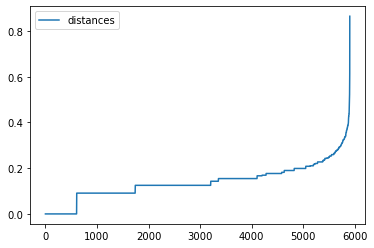

In [128]:
distance_df = pd.DataFrame({'distances':distances})

distance_df.plot(kind = 'line')

C:\Users\gspah\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=26 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


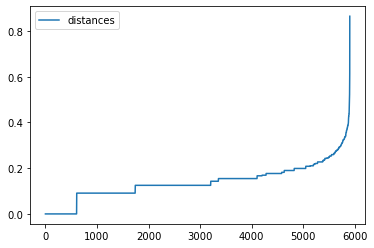

In [129]:
#code out a function to look at how this works for a few different values of mins

def elbow_fxn(min_nearest_neighbors):
    nns = NearestNeighbors(min_nearest_neighbors + 1)
    nns.fit(ml_scale)
    dist, neigh = nns.kneighbors(ml_scale)
    dist = np.sort(dist[:, min_nearest_neighbors], axis = 0)
    dist_df = pd.DataFrame({'distances': dist})
    dist_df.plot(kind = 'line')
    plt.show()

elbow_fxn(25)


C:\Users\gspah\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=11 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


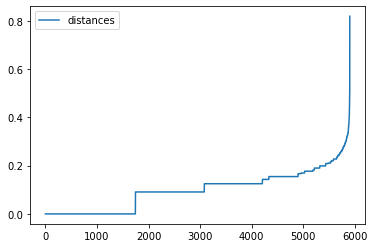

In [130]:
elbow_fxn(10)

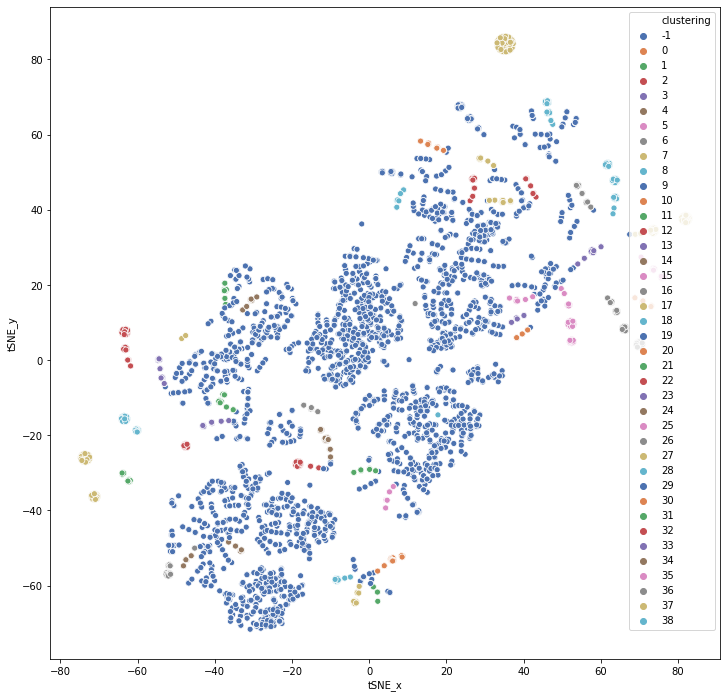

In [131]:
#elbow function is different, but still not sure I've got it right. I'm going to try a few new values for clustering (again) though, 
#based on the scales I'm seeing. 

cls_2 = DBSCAN(eps = 0.1, min_samples = 25).fit_predict(ml_scale)

#write a function to make visualizing clustering results on the t-SNE picture really easy

def cluster_vis(dbscan_array):
    vis_1['clustering'] = dbscan_array

    plt.figure(figsize = (12, 12))
    sns.scatterplot(data = vis_1, x = 'tSNE_x', y = 'tSNE_y', hue = 'clustering', palette = 'deep')

    plt.show()

cluster_vis(cls_2)
    

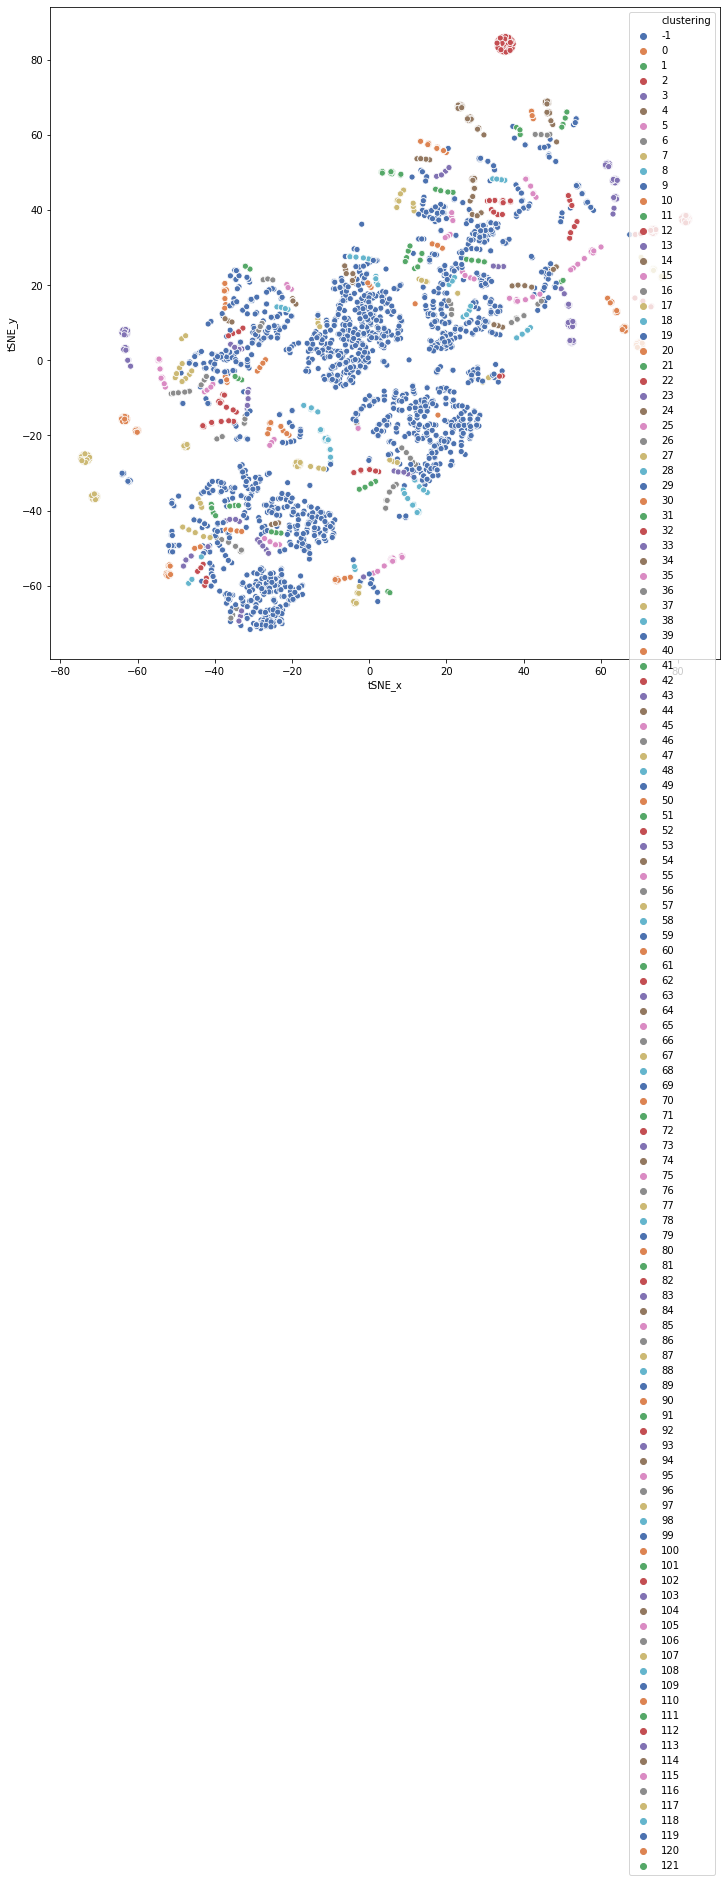

In [132]:
cls_3  = DBSCAN(eps = 0.1, min_samples = 10).fit_predict(ml_scale) 

cluster_vis(cls_3)

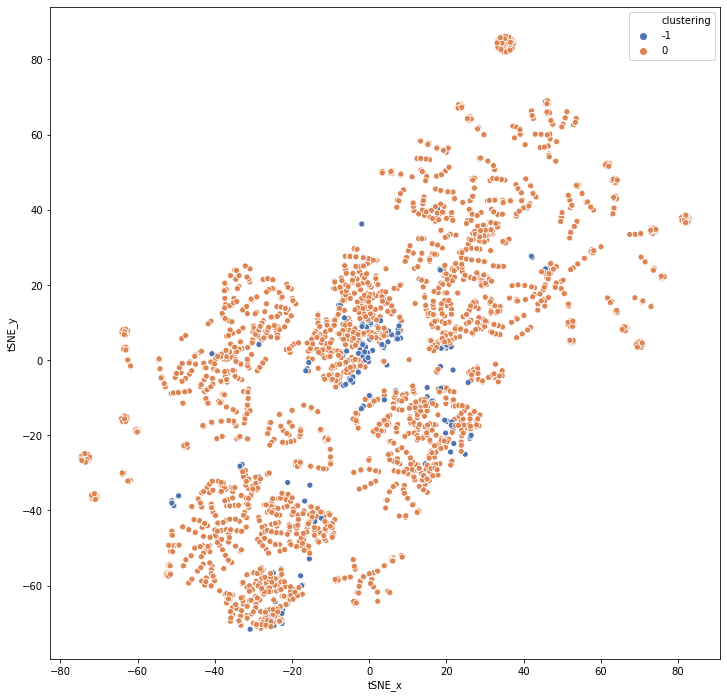

In [133]:
cls_4 = DBSCAN(eps = 0.2, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_4)

From too many to not enough.

In [134]:
#set up silhouette score
from sklearn.metrics import silhouette_score

print(f'silhouette score w noise{silhouette_score(ml_scale, cls_4)}')



silhouette score w noise0.39843522956289606


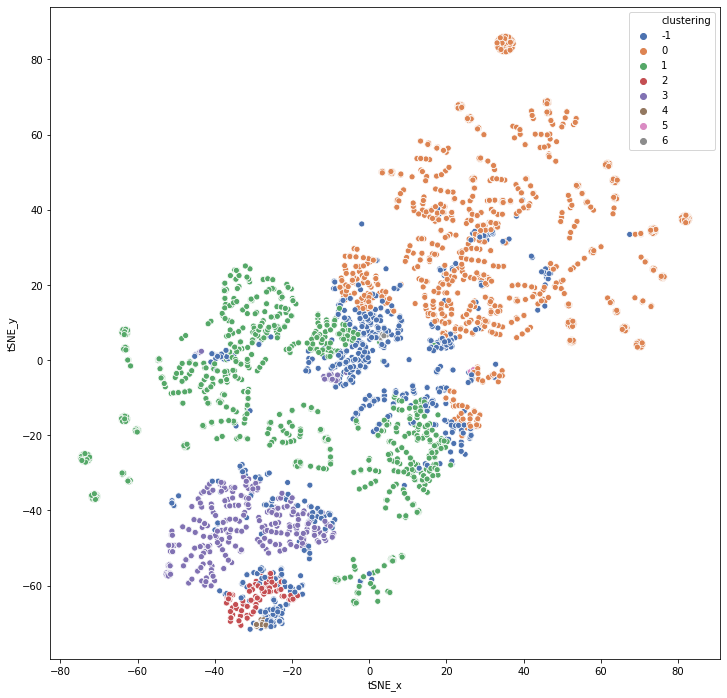

In [136]:
cls_5 = DBSCAN(eps = 0.15, min_samples = 8).fit_predict(ml_scale)

cluster_vis(cls_5)

This is potentially more interesting

In [137]:
print(f'silhouette score w noise{silhouette_score(ml_scale, cls_5)}')

silhouette score w noise0.012636922385054369


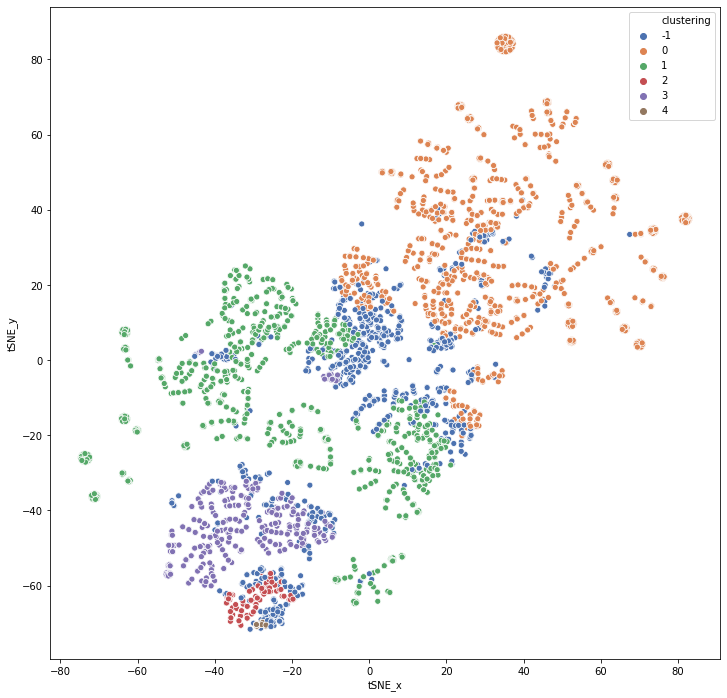

In [138]:
cls_6 = DBSCAN(eps = 0.15, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_6)

In [139]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_6)}')

silhouette score w noise 0.051456436408109194


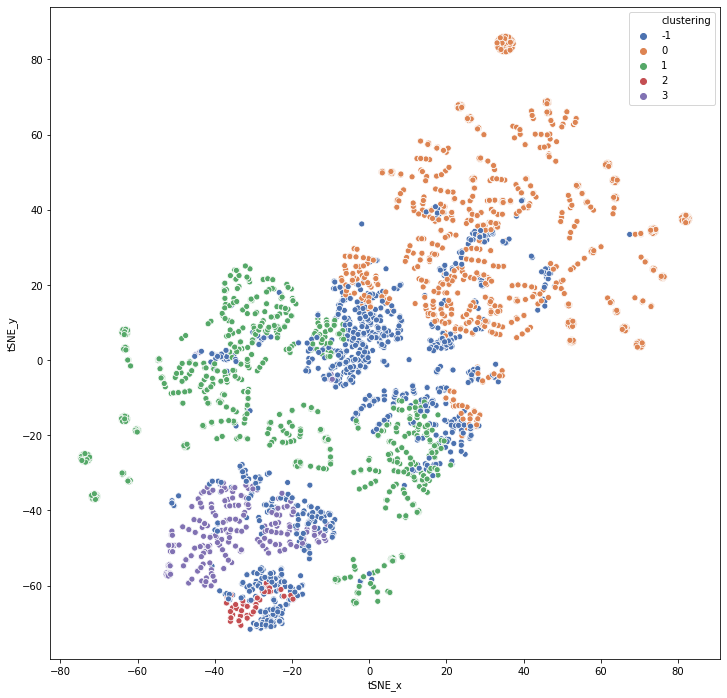

In [140]:
cls_7 = DBSCAN(eps = 0.15, min_samples = 15).fit_predict(ml_scale)

cluster_vis(cls_7)

In [141]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_7)}')

silhouette score w noise 0.037872461201824734


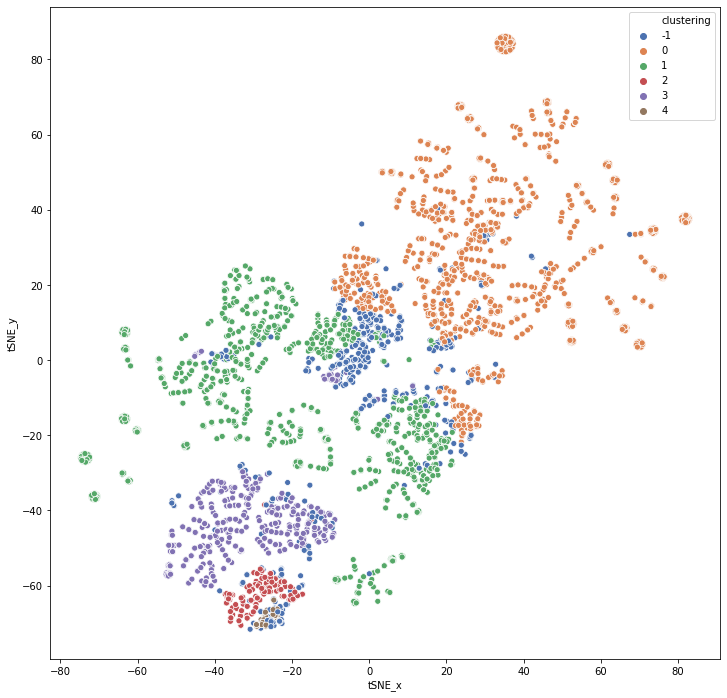

In [142]:
cls_8 = DBSCAN(eps = 0.16, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_8)

In [143]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_7)}')

silhouette score w noise 0.037872461201824734


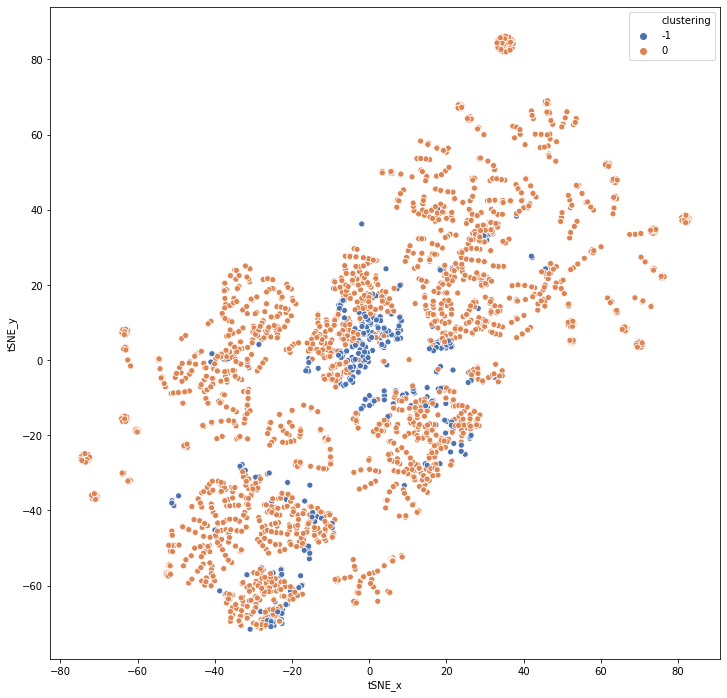

In [144]:
cls_9 = DBSCAN(eps = 0.17, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_9)

In [145]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_9)}')

silhouette score w noise 0.34967141215994824


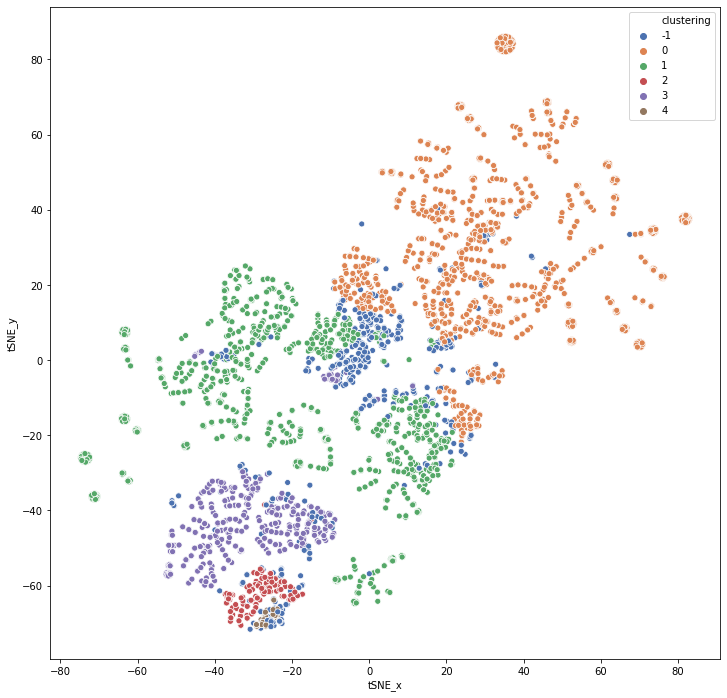

In [146]:
cls_10 = DBSCAN(eps = 0.165, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_10)

In [147]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_10)}')

silhouette score w noise 0.06677221301128296


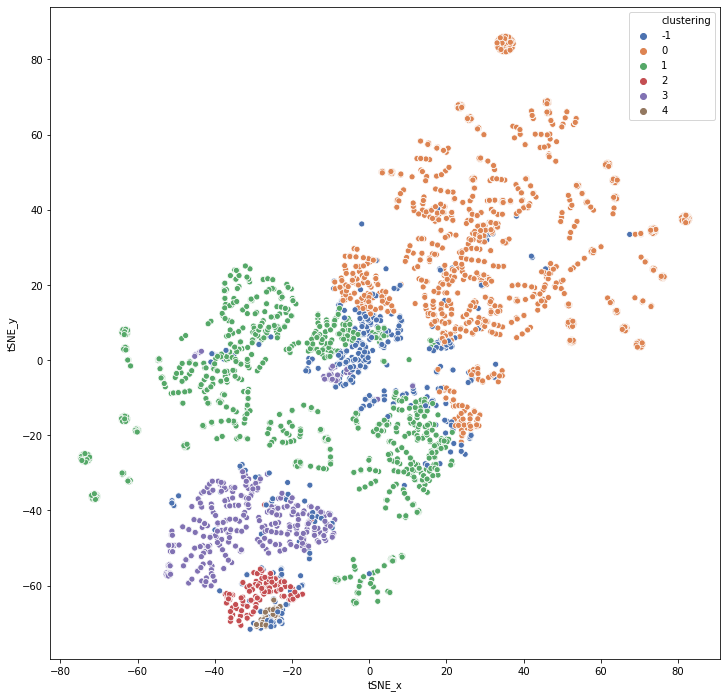

In [148]:
cls_11 = DBSCAN(eps = 0.165, min_samples = 8).fit_predict(ml_scale)

cluster_vis(cls_11)

In [149]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_11)}')

silhouette score w noise 0.06880642907461353


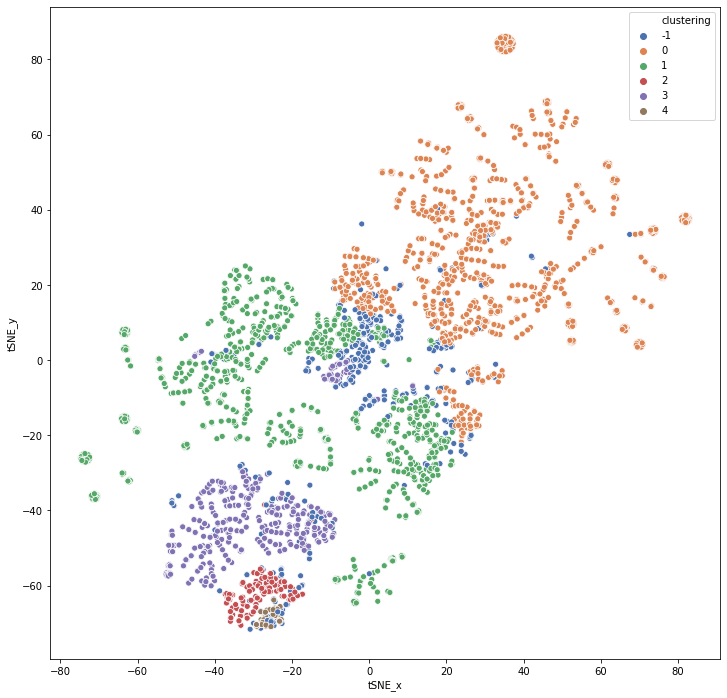

In [150]:
cls_12 = DBSCAN(eps = 0.165, min_samples = 7).fit_predict(ml_scale)

cluster_vis(cls_12)

In [151]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_12)}')

silhouette score w noise 0.07053334275824093


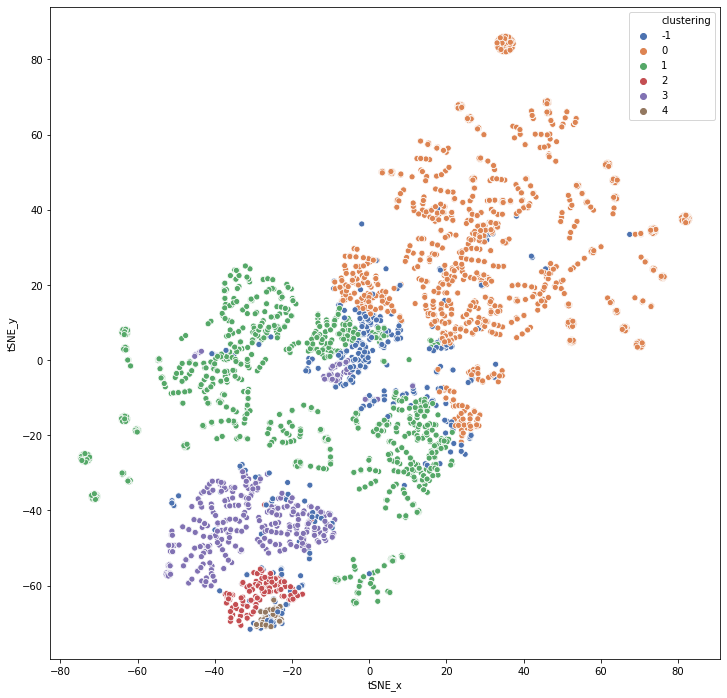

In [152]:
cls_13 = DBSCAN(eps = 0.165, min_samples = 6).fit_predict(ml_scale)

cluster_vis(cls_13)

In [153]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_13)}')

silhouette score w noise 0.07070727786258289


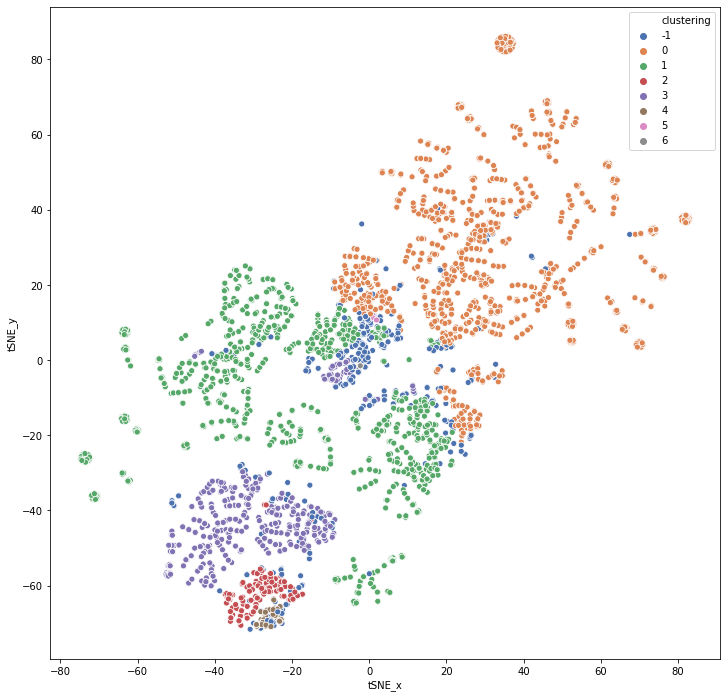

In [154]:
cls_14 = DBSCAN(eps = 0.165, min_samples = 5).fit_predict(ml_scale)

cluster_vis(cls_14)

In [155]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_14)}')

silhouette score w noise 0.04672172361076955


In [156]:
#I am going to try to extract some meaning from cls_16

ml_df_full['clustering'] = cls_13

ml_df_full.head()

,whiskey_id,fruity_words,wood_words,spicy_words,sweet_words,maillard_words,smoke_words,clustering
0,0,2,1,2,0,0,0,0
1,1,2,0,0,1,2,0,1
2,2,1,2,1,1,1,0,1
3,3,1,0,0,3,0,0,2
4,4,2,0,0,3,1,0,2


In [157]:
cluster_medians = ml_df_full.groupby('clustering').median()

cluster_medians

,whiskey_id,fruity_words,wood_words,spicy_words,sweet_words,maillard_words,smoke_words
clustering,,,,,,,
-1,2798.0,2.0,1.0,2.0,2.0,1.0,1.0
0,3207.0,1.0,1.0,1.0,0.0,1.0,0.0
1,2863.0,1.0,1.0,1.0,1.0,1.0,0.0
2,2401.0,1.0,1.0,1.0,3.0,0.0,0.0
3,2640.0,1.0,1.0,1.0,2.0,1.0,0.0
4,2597.5,1.0,1.0,1.0,4.0,0.0,0.0


Most of the categories have one fruity wood and spicy word on average. The main differences seem to come out of the sweet words and maillard words. Smoke seems to doom the whiskey to the noise category. 

In [158]:
cluster_means = ml_df_full.groupby('clustering').mean()

cluster_means

,whiskey_id,fruity_words,wood_words,spicy_words,sweet_words,maillard_words,smoke_words
clustering,,,,,,,
-1,2661.134409,2.072581,1.830645,1.938172,1.645161,2.059140,1.591398
0,3095.155807,1.263456,1.074464,1.182922,0.000000,1.048159,0.303116
1,2909.648714,1.231926,1.138282,1.219796,1.000000,1.019893,0.297914
2,2570.589189,1.318919,1.151351,0.940541,3.000000,0.594595,0.037838
3,2832.642202,1.298820,1.162516,1.129751,2.000000,0.884666,0.214941
4,2715.145833,1.166667,0.979167,0.937500,4.000000,0.645833,0.020833


In [159]:
cluster_counts = ml_df_full.groupby('clustering').count()

cluster_counts

,whiskey_id,fruity_words,wood_words,spicy_words,sweet_words,maillard_words,smoke_words
clustering,,,,,,,
-1,372,372,372,372,372,372,372
0,2471,2471,2471,2471,2471,2471,2471
1,2061,2061,2061,2061,2061,2061,2061
2,185,185,185,185,185,185,185
3,763,763,763,763,763,763,763
4,48,48,48,48,48,48,48


In [160]:
#bring in names

ds_query2 = ''' SELECT whiskey_stats.name
                FROM whiskey_stats
                '''

names = pd.read_sql(ds_query2, connct)

names.head()

,name
0,Spirit Hound Single Barrel Straight Malt (Barr...
1,Dogfish Head Straight Malt 40%
2,Balcones Texas Bock Straight Malt Whiskey 50%
3,Woodford Reserve Straight Malt Whiskey 45.2%
4,Spirit Hound Colorado Honey Malt (Barrel No. 4...


In [161]:
ml_df_full['names'] = names['name']

ml_df_full.head()

,whiskey_id,fruity_words,wood_words,spicy_words,sweet_words,maillard_words,smoke_words,clustering,names
0,0,2,1,2,0,0,0,0,Spirit Hound Single Barrel Straight Malt (Barr...
1,1,2,0,0,1,2,0,1,Dogfish Head Straight Malt 40%
2,2,1,2,1,1,1,0,1,Balcones Texas Bock Straight Malt Whiskey 50%
3,3,1,0,0,3,0,0,2,Woodford Reserve Straight Malt Whiskey 45.2%
4,4,2,0,0,3,1,0,2,Spirit Hound Colorado Honey Malt (Barrel No. 4...


In [162]:
c4 = ml_df_full[ml_df_full['clustering'] == 4]

c4.head()

,whiskey_id,fruity_words,wood_words,spicy_words,sweet_words,maillard_words,smoke_words,clustering,names
60,60,1,2,1,4,2,0,4,Michter's US*1 Small Batch Unblended American ...
99,99,2,2,2,4,0,0,4,Nant Bourbon Cask 43%
163,163,0,0,0,4,0,0,4,Black Eagle Honey 35%
337,337,3,1,3,4,1,0,4,Usquaebach An Ard Ri Cask Strength 57.1%
360,360,2,1,0,4,0,0,4,Timorous Beastie 18 year old 46.8%


In [163]:
c3 = ml_df_full[ml_df_full['clustering'] == 3]

c3.head()

,whiskey_id,fruity_words,wood_words,spicy_words,sweet_words,maillard_words,smoke_words,clustering,names
11,11,2,2,4,2,2,0,3,Barrell Private Release Malmsey Madeira Cask-F...
13,13,1,0,0,2,3,0,3,Jacob’s Pardon 15 year old Single Barrel Ameri...
16,16,0,2,0,2,2,0,3,Jacob's Pardon 15 year old Single Barrel Ameri...
18,18,3,1,0,2,2,0,3,Barrell Private Release Calvados Cask-Finished...
28,28,0,2,1,2,0,0,3,Hooten Young 12 year old Whiskey (Batch 1) 46%


In [164]:
c2 = ml_df_full[ml_df_full['clustering'] == 2]

c2.head()

,whiskey_id,fruity_words,wood_words,spicy_words,sweet_words,maillard_words,smoke_words,clustering,names
3,3,1,0,0,3,0,0,2,Woodford Reserve Straight Malt Whiskey 45.2%
4,4,2,0,0,3,1,0,2,Spirit Hound Colorado Honey Malt (Barrel No. 4...
5,5,1,0,0,3,0,0,2,Parker’s Heritage Collection Kentucky Straight...
7,7,2,0,1,3,0,0,2,Woodford Reserve Master’s Collection Classic M...
17,17,1,3,0,3,1,0,2,Proof and Wood 25 year old 100 Seasons America...


In [165]:
c1 = ml_df_full[ml_df_full['clustering'] == 1]

c1.head()

,whiskey_id,fruity_words,wood_words,spicy_words,sweet_words,maillard_words,smoke_words,clustering,names
1,1,2,0,0,1,2,0,1,Dogfish Head Straight Malt 40%
2,2,1,2,1,1,1,0,1,Balcones Texas Bock Straight Malt Whiskey 50%
6,6,0,4,1,1,1,0,1,Woodford Reserve Master’s Collection Straight ...
9,9,0,2,1,1,1,0,1,Barrell Private Release Tokaji Cask-Finished K...
19,19,3,0,3,1,1,0,1,Barrell Private Release Sicilian Amaro Cask-Fi...


In [166]:
c0 = ml_df_full[ml_df_full['clustering'] == 0]

c0.head()

,whiskey_id,fruity_words,wood_words,spicy_words,sweet_words,maillard_words,smoke_words,clustering,names
0,0,2,1,2,0,0,0,0,Spirit Hound Single Barrel Straight Malt (Barr...
10,10,5,1,1,0,3,0,0,Barrell Private Release Ruby Port Cask-Finishe...
12,12,3,2,5,0,1,0,0,Barrell 25 year old Cask-Strength American Whi...
14,14,4,2,0,0,1,0,0,Barrell Private Release Hermann J. Wiemer Nobl...
15,15,2,2,1,0,1,0,0,Barrell Private Release St. Agrestis Brooklyn ...


The algorythm very clearly picked up on differences in sweetness exclusively on this clustering attempt. This is going to be something worth looking into. I think it's time to reengineer the features again though, to expand the feature words further, and to normalize categories to the number of words used in the review. 

In [167]:
connct.close()

Second thought: It might not be surprising that the algorythm found a simple pattern based on sweet words with no other nuance based on the range of the clusters. There is clearly finer structure to the clusters in the tSNE, so maybe I should constrain epsilon to lower values and look at a larger number of clusters. If I want small groups of very similar whiskies, this is clearly how I would tell that and it seems like large groups are most likely to rely on the presence of a unique word, or a common feature. 